This notebook is designed to explore the effects of:
- calibrating
- quantising
- sorting & filtering top 4 jets

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import matplotlib as mpl
%matplotlib inline

In [3]:
pd.__version__, scipy.__version__, np.__version__, mpl.__version__

('0.16.1', '0.15.1', '1.9.2', '1.4.3')

In [4]:
mpl.rcParams['figure.figsize'] = (14.0, 6.0)  # default size of plots
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
# mpl.rcParams['xtick.major.size'] = 10
# mpl.rcParams['ytick.major.size'] = 10
# mpl.rcParams['xtick.minor.size'] = 5
# mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.9
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['legend.scatterpoints'] = 1

# Setup

Define our eta bins:

In [5]:
eta_bins = [0.0, 0.348, 0.695, 1.044, 1.392, 1.74, 2.172, 3.0, 3.5, 4.0, 4.5, 5]
eta_bins_all = [-5, -4.5, -4.0, -3.5, -3.0, -2.172, -1.74, -1.392, -1.044, -0.695, -0.348, 0.0, 0.348, 0.695, 1.044, 1.392, 1.74, 2.172, 3.0, 3.5, 4.0, 4.5, 5]

We need to define a format to hold info about our jets, both the L1 jets and their reference jet match. Use a numpy record array for this, as then we can vectorise our operations in future.

In [6]:
# Define fields for L1 pt, L1 eta, Ref pt. We'll assume Ref eta = L1 eta 
# since they're matches, and we're not interested in testing matching.
# All of these are floats.
fields = ['pt', 'eta', 'ptRef']

def make_jet_pairs(pt, eta, ptRef):
    """Basically an alias for np.core.records.fromarrays()"""
    return np.core.records.fromarrays([pt, eta, ptRef], names=','.join(fields))

In [7]:
# An example of making a numpy recarray
pt_in = [1, 2, 3]
eta_in = [0.1, 0.2, 0.3]
ptRef_in = [1.1, 2.1, 3.1]

input_jets = make_jet_pairs(pt_in, eta_in, ptRef_in)
print input_jets
print type(input_jets)
print input_jets.dtype # list field names and types
print input_jets.pt # access fields via their names
print type(input_jets.pt) # they're just numpy arrays
print input_jets[1] # access records by their index

[(1, 0.1, 1.1) (2, 0.2, 2.1) (3, 0.3, 3.1)]
<class 'numpy.core.records.recarray'>
[('pt', '<i8'), ('eta', '<f8'), ('ptRef', '<f8')]
[1 2 3]
<type 'numpy.ndarray'>
(2, 0.2, 2.1)


Let's define some helper functions for our trigger emulator:

In [8]:
def lut_to_dict(lut_file):
    """Convert LUT to dict, where key is address, 
    and value is post-calibration rank"""
    with open(lut_file, 'r') as f:
        return {int(line.split()[0]): int(line.split()[1]) for line in f if not line.startswith('#')}

    
def quantise(pt, LSB):
    """Quantise pt to LSB. This works exaclty 
    like integer division - any modulus is discarded.

    If LSB <= 0, no quantisation occurs.

    >>> quantise(5, 4)
    4
    >>> quantise (10.7, 0.5)
    10.5
    >>> quantise (10.7, 0)
    10.7
    """
    if LSB > 0:
        # casting different for numpy array and builtin int
        # TODO: use floor()?
        if isinstance(pt, np.ndarray):
            return (pt / float(LSB)).astype(int) * LSB * 1.0
        else:
            return int(pt / float(LSB)) * LSB * 1.0
    else:
        return pt

    
def eta_to_region(eta):
    """Convert physical eta to HW eta region
    
    >>> eta_to_region(0.192)
    11
    """
    if abs(eta) > 5:
        raise IndexError("Physical eta out of range [-5, 5]")
    return next(i-1 for i,x in enumerate(eta_bins_all) if eta_bins_all[i] > eta)


def convert_to_address(pt, eta):
    """Convert physical pt, eta to address for LUT
    
    >>> convert_to_address(511.5, 4.75)
    22527
    """
    # quantise pt to 0.5 GeV as per internal jets
    pt_hw = quantise(pt, 0.5)
    # convert to HW pt
    pt_hw *= 2
    # convert physical eta to HW eta
    eta_hw = eta_to_region(eta)
    return (eta_hw<<10) + int(pt_hw)

Let's define a basic trigger emulator class that will take in a set of jets and do:

- calibrating
- quantising

In [9]:
class CalibEmu(object):
    """Class to replicate part of L1 trigger that 
    calibrates, sorts, and quantises jets."""
    
    def __init__(self, calib_fns=None, lut_file=None):
        self.calib_fns = calib_fns
        self.lut = lut_to_dict(lut_file) if lut_file else None
        
    def get_output_jets(self, input_jets, LSB=4, calibrate='lut'):
        """Get the output collection of jets using input_jets.
        
        input_jets: recarray. Needs fields pt and eta.
        
        LSB: float. Choose LSB for quantisation of output jets.
        4 corresponds to what is used in the trigger.
        0 applies no quantisation.
        
        calibrate: string. Choose whether to apply calibrations to jets, 
        and the source of calibration values:

            'function': uses the calibration functions stored in the 
            object to calculate the correciton function
        
            'lut': uses the lookup table. Applies a quantisation with LSB = 4 
            to output jets.
        
            None: does not apply any calibrations.
        """
        # make a copy, don't touch original
        output_jets = input_jets.copy()
        
        # apply calibration functions
        if calibrate:
            if calibrate.lower() == "lut":
                if not self.lut:
                    raise RuntimeError('No LUT to use for calibrations')
                else:
                    pass
            elif calibrate.lower() == "function":
                if not self.calib_fns:
                    raise RuntimeError('No functions to use for calibrations')
                else:
                    pass
                
        # quantise output jets
        output_jets.pt = quantise(output_jets.pt, LSB)
        
        return output_jets

Let's setup an instance of our emulator with the V3 corrections:

In [10]:
s1 = CalibEmu(calib_fns=None, 
              lut_file="/Users/robina/L1/L1Trigger/L1JetEnergyCorrections/data/Jet_Stage1_2015_v3.txt")

# Quantising effects 

The first thing to investigate is the effects of quantising our output jets. The jets that are produced by the trigger have a LSB = 4 GeV, and the internal jets have a LSB = 0.5 GeV. These can have import effects on the response (and possibly resolution?)

## Super simple - Single reference jet value 

Let's start with a single reference jet pt at 20, and let our L1 jets have some Gaussian distribution about that reference pt.

In [11]:
N = 100000
ptRef_in = np.ones(N) * 20  # delta function
pt_in = np.array([np.random.normal(loc=x, scale=1) for x in ptRef_in]) # normal distribution for each L1 jet
eta_in = np.ones(N) * 0.16 # just pick one eta bin

jets = make_jet_pairs(pt_in, eta_in, ptRef_in)

Plot the L1 and reference jet pt distributions without any quanitsation:

In [12]:
# Some common strings for plots
pt_str = r'$p_{T}$'
ptL1_str = r'$p_{T}^{L1}$'
ptRef_str = r'$p_{T}^{Ref}$'
rsp_str = r'$\mathrm{response}\ =\ p_{T}^{L1}/p_{T}^{Ref}$'

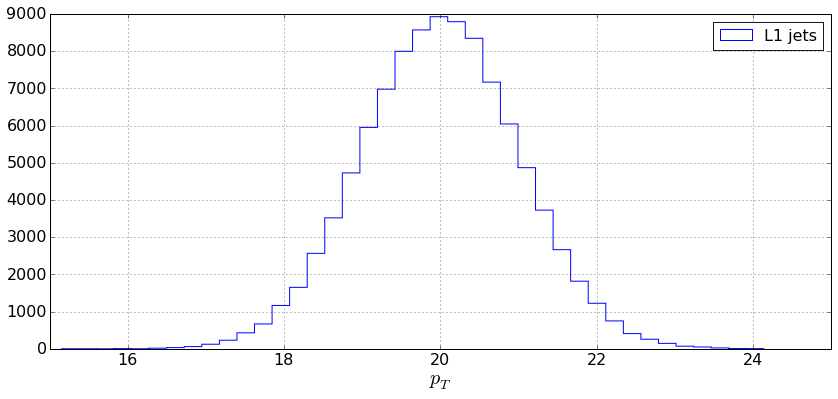

In [13]:
# plt.hist(input_jets.ptRef, bins=40, range=[16, 24], label='Reference jets')
plt.hist(jets.pt, bins=40, label='L1 jets', histtype='step')
plt.xlabel(pt_str)
plt.legend(loc=0)
plt.grid(which='both')

We now quantise our L1 jets, to LSBs 0.5 and 4. This will simulate our internal and output jet collections, respectively.

In [14]:
jets_intern = s1.get_output_jets(jets, LSB=0.5, calibrate=None)
jets_out = s1.get_output_jets(jets, LSB=4, calibrate=None)

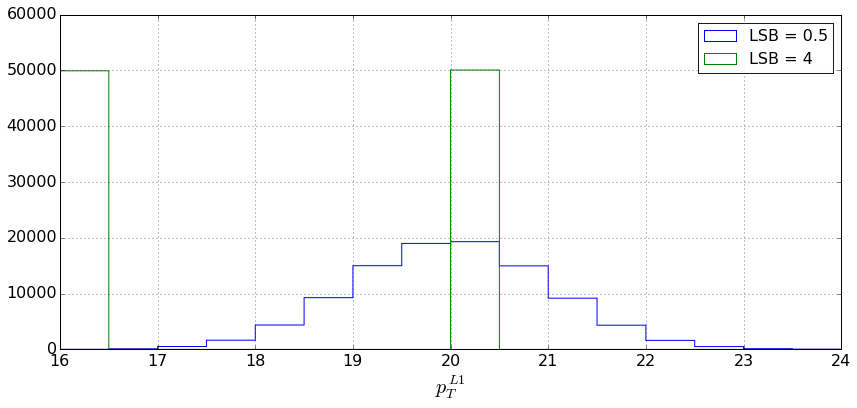

In [15]:
plt.hist(jets_intern.pt, bins=16, range=[16, 24], label='LSB = 0.5', histtype='step')
plt.hist(jets_out.pt, bins=16, range=[16, 24], label='LSB = 4', histtype='step')
plt.xlabel(ptL1_str)
plt.legend(loc=0)
plt.grid(which='both')

In [16]:
print 'Mean of LSB = 4 collection:', np.mean(jets_out.pt)

Mean of LSB = 4 collection: 18.0026


Interestingly, because of the quantisation, the mean pT of the jets_out collection is about 18. Thus we can infer that any calibrations we test using the L1 jets with LSB = 4 will therefore always look **under-calibrated**, even if they are doing the right job.

Now let's calulate the response values and plot a histogram.

In [17]:
rsp_intern = jets_intern.pt / ptRef_in # smaller LSB response
rsp_out = jets_out.pt / ptRef_in # larger LSB response

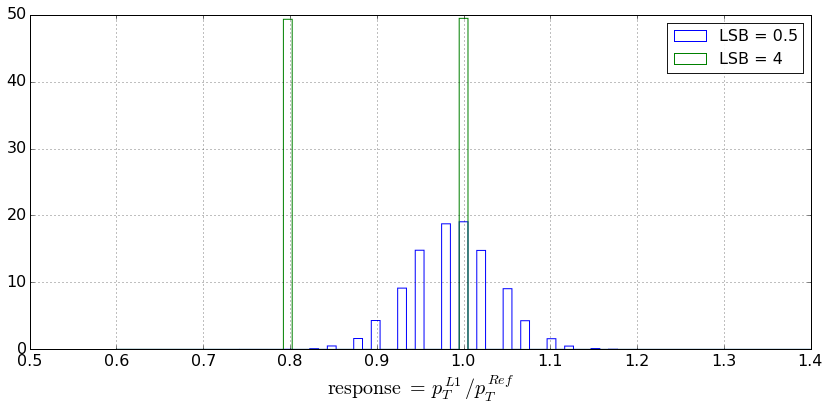

In [18]:
range_x = [0.6, 1.4]
nbins = (range_x[1]-range_x[0])/0.01
normed = True
plt.hist(rsp_intern, bins=nbins, normed=normed, range=range_x, label="LSB = 0.5", histtype='step')
plt.hist(rsp_out, bins=nbins, normed=normed, range=range_x, label="LSB = 4", histtype='step')
plt.legend(loc=0)
plt.grid(which='both')
plt.xlabel(rsp_str)

In [19]:
print 'Mean response using jet_intern (LSB = 0.5):', np.mean(rsp_intern)
print 'Mean response using jet_out (LSB = 4):', np.mean(rsp_out)

Mean response using jet_intern (LSB = 0.5): 0.98743025
Mean response using jet_out (LSB = 4): 0.90013


So as predicted, the mean response is about 10% lower when we use LSB = 4. This 10% originates form the fact that the mean pt is shfited by about 0.5 * LSB, and for ptRef = 20, this corresponds to a drop in mean response of 10%. Similarly, for LSB = 0.5, we except a drop of about 0.25 / 20 = 0.0125 in mean response. Of course here we are limited because we only have 1 reference jet value. The next step is to look at a distribution of reference pt values.

## Uniform reference jet distribution over a small interval

We now try another scenario that is closer to a real issue: where the refence jets have uniform distribution over a relatively small interval. This is akin to one pt(ref) bin in some of the studies. We'll again assume that each L1 jet has some pt which is randomly picked from a Gaussian with mean = ptRef, and some constant width. We'll create 2 sets of L1 jets - one with a narrow Gaussian width, and one with a wide Gaussian width.

In [160]:
N = 100000
ptRef_in = np.random.uniform(18, 22, N)
# normal distribution for each L1 jet with small width
pt_in_narrow = np.array([np.random.normal(loc=x, scale=0.5) for x in ptRef_in]) 
# normal distribution for each L1 jet with large width
pt_in_wide = np.array([np.random.normal(loc=x, scale=2) for x in ptRef_in]) 
eta_in = np.ones(N) * 0.16 # just pick one eta bin

jets_narrow = make_jet_pairs(pt_in_narrow, eta_in, ptRef_in)
jets_wide = make_jet_pairs(pt_in_wide, eta_in, ptRef_in)

Repeat the same plots as before:

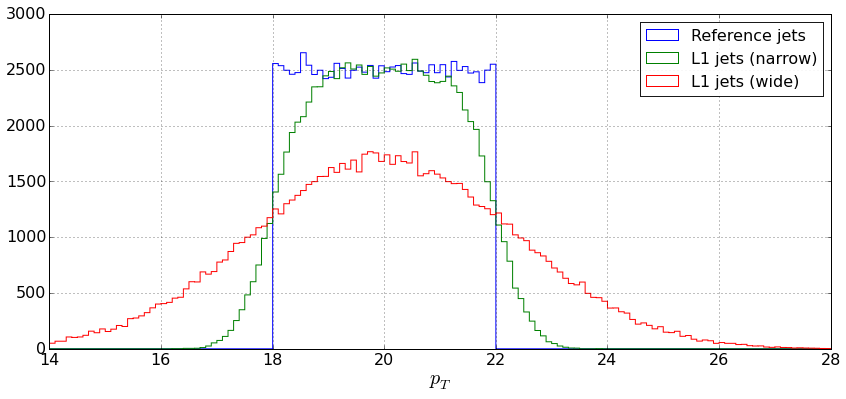

In [161]:
x_range = [14, 28]
nbins = (x_range[1] - x_range[0])/0.1
plt.hist(jets_wide.ptRef, bins=nbins, range=x_range, label='Reference jets', histtype='step')
plt.hist(jets_narrow.pt, bins=nbins, range=x_range, label='L1 jets (narrow)', histtype='step')
plt.hist(jets_wide.pt, bins=nbins, range=x_range, label='L1 jets (wide)', histtype='step')
plt.xlabel(pt_str)
plt.legend(loc=0)
plt.grid(which='both')

Interestingly, the L1 (post-smearing) distribution is like a very wide Gaussian. Obviously this is due to the chosen width of the Gaussian smearing function.

Let's now quantise our jet collections, for both LSB = 0.5 and LSB = 4.

In [162]:
jets_narrow_intern = s1.get_output_jets(jets_narrow, LSB=0.5, calibrate=None)
jets_narrow_out = s1.get_output_jets(jets_narrow, LSB=4, calibrate=None)
jets_wide_intern = s1.get_output_jets(jets_wide, LSB=0.5, calibrate=None)
jets_wide_out = s1.get_output_jets(jets_wide, LSB=4, calibrate=None)

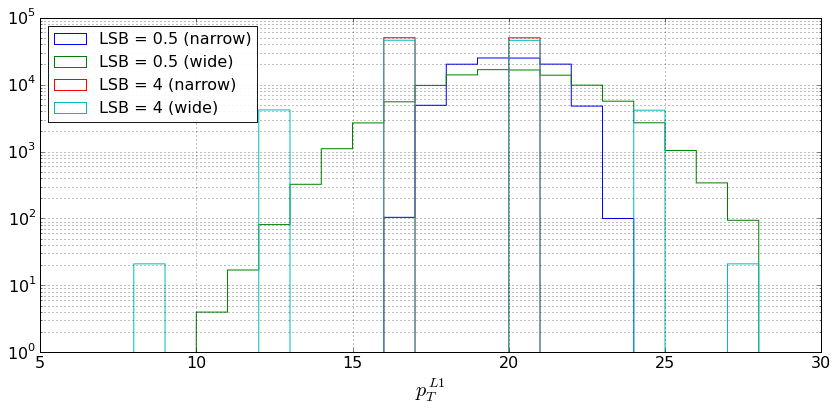

In [163]:
x_range = [8, 28]
nbins = (x_range[1] - x_range[0])
plt.hist(jets_narrow_intern.pt, bins=nbins, range=x_range, label='LSB = 0.5 (narrow)', histtype='step')
plt.hist(jets_wide_intern.pt, bins=nbins, range=x_range, label='LSB = 0.5 (wide)', histtype='step')
plt.hist(jets_narrow_out.pt, bins=nbins, range=x_range, label='LSB = 4 (narrow)', histtype='step')
plt.hist(jets_wide_out.pt, bins=nbins, range=x_range, label='LSB = 4 (wide)', histtype='step')
plt.xlabel(ptL1_str)
plt.legend(loc=2)
plt.grid(which='both')
plt.yscale('log')

In [164]:
print 'Mean of LSB = 0.5 collection (narrow Gaussian):', np.mean(jets_narrow_intern.pt)
print 'Mean of LSB = 0.5 collection (wide Gaussian):', np.mean(jets_wide_intern.pt)
print 'Mean of LSB = 4 collection (narrow Gaussian):', np.mean(jets_narrow_out.pt)
print 'Mean of LSB = 4 collection (wide Gaussian):', np.mean(jets_wide_out.pt)

Mean of LSB = 0.5 collection (narrow Gaussian): 19.745555
Mean of LSB = 0.5 collection (wide Gaussian): 19.75083
Mean of LSB = 4 collection (narrow Gaussian): 17.99688
Mean of LSB = 4 collection (wide Gaussian): 17.99492


Let's now look at the response distribution for each collection:

In [165]:
rsp_narrow_intern = jets_narrow_intern.pt / jets_narrow.ptRef # smaller LSB response
rsp_narrow_out = jets_narrow_out.pt / jets_narrow.ptRef # larger LSB response
rsp_wide_intern = jets_wide_intern.pt / jets_wide.ptRef # smaller LSB response
rsp_wide_out = jets_wide_out.pt / jets_wide.ptRef # larger LSB response

(0.6, 1.3)

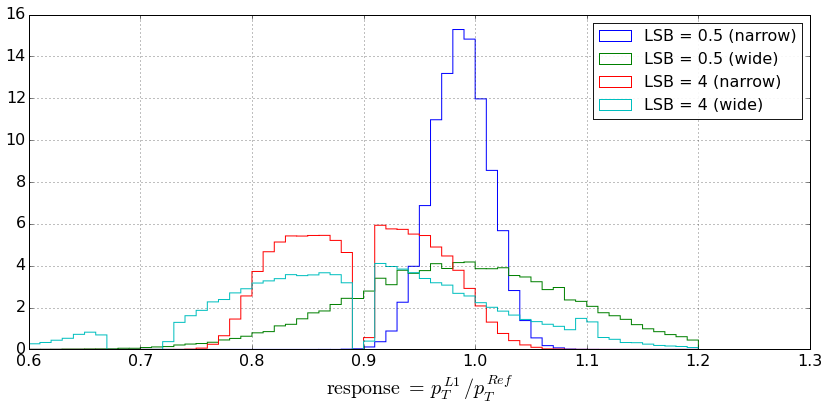

In [166]:
range_rsp = [0.6, 1.2]
nbins_rsp = (range_rsp[1]-range_rsp[0])/0.01
normed = True
plt.hist(rsp_narrow_intern, bins=nbins_rsp, normed=normed, range=range_rsp, label="LSB = 0.5 (narrow)", histtype='step')
plt.hist(rsp_wide_intern, bins=nbins_rsp, normed=normed, range=range_rsp, label="LSB = 0.5 (wide)", histtype='step')
plt.hist(rsp_narrow_out, bins=nbins_rsp, normed=normed, range=range_rsp, label="LSB = 4 (narrow)", histtype='step')
plt.hist(rsp_wide_out, bins=nbins_rsp, normed=normed, range=range_rsp, label="LSB = 4 (wide)", histtype='step')
plt.legend(loc=0)
plt.grid(which='both')
plt.xlabel(rsp_str)
plt.xlim(left=0.6)
# plt.yscale('log')

Now we see something really interesting - because of the larger quantisation, there are some values of response which are just non-existant, here at 0.7 and 0.9. And there is an extra peak at 1.1. Let's look at the limits of ptRef, and the L1 values:
- if L1 = 24, then 24/22 = 1.091 < rsp < 24/18 = 1.333
- if L1 = 20, then 20/22 = 0.909 < rsp < 20/18 = 1.111
- if L1 = 16, then 16/22 = 0.72 < rsp < 16/18 = 0.888
- if L1 = 12, then 12/22 = 0.545 < rsp < 12/18 = 0.666

So there are no possible entries between 0.888 and 0.909, purely because of the quantisation. (Similar story between 0.666 and 0.72). Note that above pt = 24, there are overlaps and thus no 'impossible' values. Infact, these overlaps will give rise to additional peaks.

It's clearer if we plot a 2D histogram to show which pt bins contribute to which 'peak'

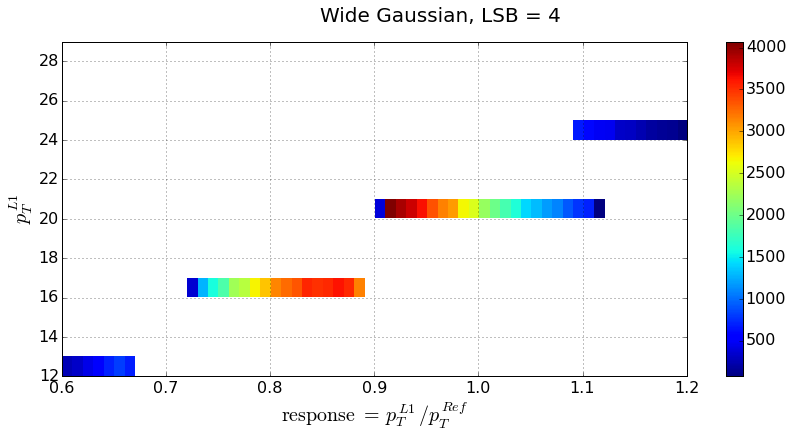

In [167]:
a,b,c,d = plt.hist2d(rsp_wide_out, jets_wide_out.pt, cmin=0.1, bins=[nbins_rsp, 17], range=[range_rsp, [12, 29]])
plt.ylabel(ptL1_str)
plt.xlabel(rsp_str)
plt.colorbar()
plt.suptitle('Wide Gaussian, LSB = 4', fontsize=20)
plt.grid(which='both')

One other way to view the missing and peaking values is by plotting ptRef vs response:

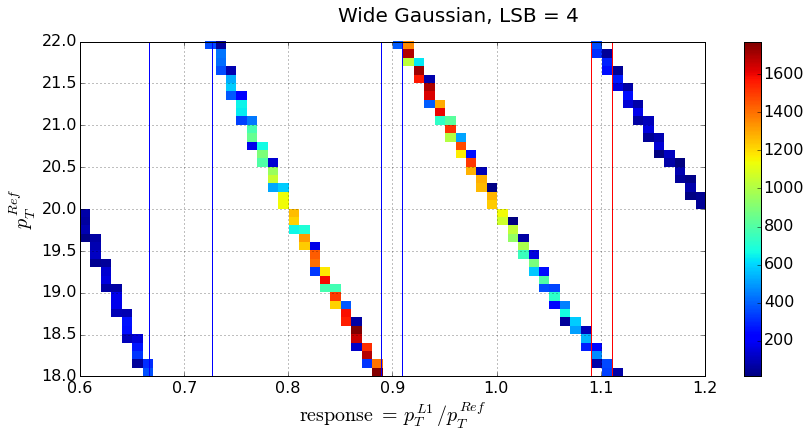

In [168]:
a,b,c,d = plt.hist2d(rsp_wide_out, jets_wide_out.ptRef, cmin=0.1, bins=[nbins_rsp, 40], range=[range_rsp, [18, 22]])
plt.xlabel(rsp_str)
plt.ylabel(ptRef_str)
plt.axvline(24./22., c='red')
plt.axvline(20./18., c='red')
plt.axvline(16./18.)
plt.axvline(20./22.)
plt.axvline(16./22.)
plt.axvline(12./18.)
plt.legend(loc=0)
plt.colorbar()
plt.suptitle("Wide Gaussian, LSB = 4", fontsize=20)
plt.grid(which='both')

To compare, let's show the same plot but for wide Guassian, with LSB = 0.5:

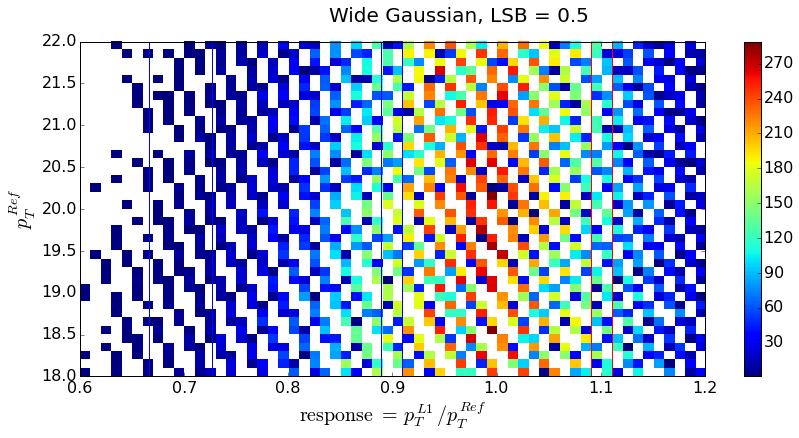

In [169]:
a,b,c,d = plt.hist2d(rsp_wide_intern, jets_wide_out.ptRef, cmin=0.1, bins=[nbins_rsp, 40], range=[range_rsp, [18, 22]])
plt.xlabel(rsp_str)
plt.ylabel(ptRef_str)
plt.axvline(24./22., c='red')
plt.axvline(20./18., c='red')
plt.axvline(16./18.)
plt.axvline(20./22.)
plt.axvline(16./22.)
plt.axvline(12./18.)
plt.legend(loc=0)
plt.colorbar()
plt.suptitle("Wide Gaussian, LSB = 0.5", fontsize=20)

There are several notable features here:
- because we have a quantised pt, this maps into 'contours' of $y = 1/x$, for each value of pT. The distance between contours depends on the LSB.
- The response histogram is the projection of this 2D plot onto the x axis. As a result, we can start to see how some peaks are formed: if contours fail to overlap (such as ~ 0.7, and 0.9) we get no entries, marked by the blue lines. But at around 1.1, they overlap, and thus gives rise to another peak, marked by the red lines.
- Even with a 'good' resolution and calibration (the narrow collection), we *still* have the gap at 0.9 for LSB = 4, making the distribution look bizarre.

**This is all because we plot in bins of *reference* jet pT. Plotting in bins of L1 pT would potentially make life easier.** However it does mean you cannot compare the calibration derivation curves with the post-cailbration curves, since each bin has different objects.

## Conclusion

Quantisation to 4 GeV (i.e. comparable to the jet energy, here ~ 20) can cause issues with distributions that depends on the jet pT (e.g. response), even if your have really well calibrated jets.

**Aside:** Note that the response histogram doesn't look much like our mystery spectrum: for our L1 jets we essentially have a nice Gaussian with a chunk removed at ~ 0.9, whereas the real plot is much more chaotic. There could be several reasons for this:
- our Guassian width could be wrong
- we assumed nicely calibrated L1 jets which are distributed Gaussianly about some mean. In reality, we know that these jets are likely over-corrected, and the Gaussian approximation may not be not very accurate.
- we assumed a uniform ptRef distribtuion, but in reality it has some upward or downward gradient (actually it turns out to be a resonable assumption - there is a slighty preference towards higher ptRef values but it is very minor)

But more crucially it shows that even **if** we had L1 pt with a Gaussian distribution about their matching reference jet value, we **still** get a weird response distribution, purely because of the large LSB. If you compare this with the LSB = 0.5, you can see the effect is mitigated.

Also note that one could try fitting a Gaussian to the LSB = 4 histogram, ignoring the parts missing at 0.7 and 0.9. However, compare the peak with the LSB = 0.5 - it would be at ~ 0.9, and not 1, even though we know the jets **are** properly calibrated. So the LSB = 4 still affects things (as seen before in teh simple scenario section above).

## Repeating with larger $p_T$ bin

We now repeat the above procedure but with a larger pt bin, 58-62, to see if things fare better here.

In [170]:
N = 100000
ptRef_in = np.random.uniform(58, 62, N)
# normal distribution for each L1 jet with small width
pt_in_narrow = np.array([np.random.normal(loc=x, scale=0.5) for x in ptRef_in]) 
# normal distribution for each L1 jet with large width
pt_in_wide = np.array([np.random.normal(loc=x, scale=2) for x in ptRef_in]) 
eta_in = np.ones(N) * 0.16 # just pick one eta bin

jets_narrow = make_jet_pairs(pt_in_narrow, eta_in, ptRef_in)
jets_wide = make_jet_pairs(pt_in_wide, eta_in, ptRef_in)

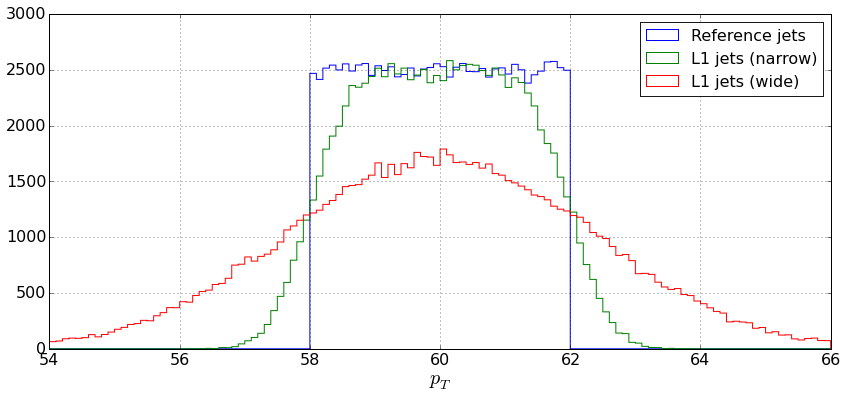

In [171]:
x_range = [54, 66]
nbins = (x_range[1] - x_range[0])/0.1
plt.hist(jets_wide.ptRef, bins=nbins, range=x_range, label='Reference jets', histtype='step')
plt.hist(jets_narrow.pt, bins=nbins, range=x_range, label='L1 jets (narrow)', histtype='step')
plt.hist(jets_wide.pt, bins=nbins, range=x_range, label='L1 jets (wide)', histtype='step')
plt.xlabel(pt_str)
plt.legend(loc=0)
plt.grid(which='both')

In [172]:
jets_narrow_intern = s1.get_output_jets(jets_narrow, LSB=0.5, calibrate=None)
jets_narrow_out = s1.get_output_jets(jets_narrow, LSB=4, calibrate=None)
jets_wide_intern = s1.get_output_jets(jets_wide, LSB=0.5, calibrate=None)
jets_wide_out = s1.get_output_jets(jets_wide, LSB=4, calibrate=None)

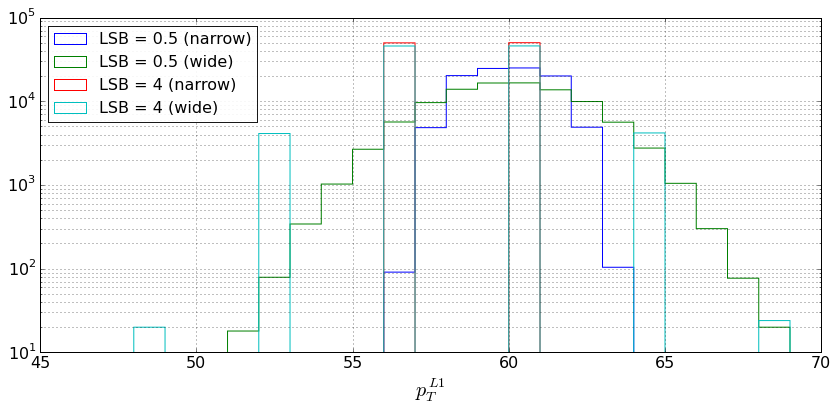

In [173]:
x_range = [45, 70]
nbins = (x_range[1] - x_range[0])
plt.hist(jets_narrow_intern.pt, bins=nbins, range=x_range, label='LSB = 0.5 (narrow)', histtype='step')
plt.hist(jets_wide_intern.pt, bins=nbins, range=x_range, label='LSB = 0.5 (wide)', histtype='step')
plt.hist(jets_narrow_out.pt, bins=nbins, range=x_range, label='LSB = 4 (narrow)', histtype='step')
plt.hist(jets_wide_out.pt, bins=nbins, range=x_range, label='LSB = 4 (wide)', histtype='step')
plt.xlabel(ptL1_str)
plt.legend(loc=2)
plt.grid(which='both')
plt.yscale('log')

In [174]:
rsp_narrow_intern = jets_narrow_intern.pt / jets_narrow.ptRef # smaller LSB response
rsp_narrow_out = jets_narrow_out.pt / jets_narrow.ptRef # larger LSB response
rsp_wide_intern = jets_wide_intern.pt / jets_wide.ptRef # smaller LSB response
rsp_wide_out = jets_wide_out.pt / jets_wide.ptRef # larger LSB response

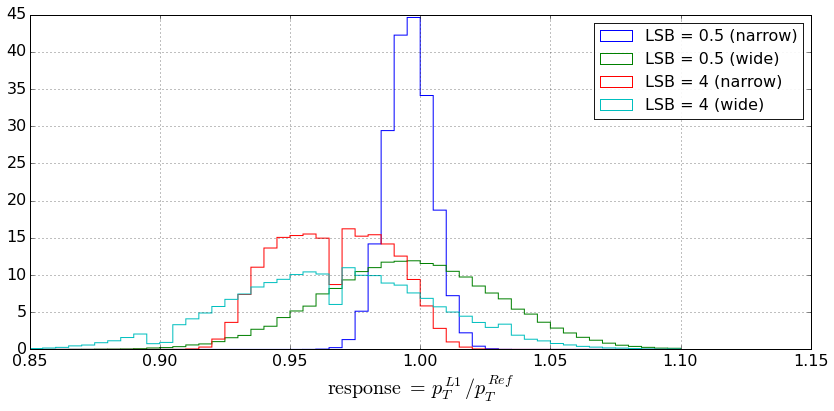

In [175]:
range_rsp = [0.85, 1.1]
nbins_rsp = (range_rsp[1]-range_rsp[0])/0.005
normed = True
plt.hist(rsp_narrow_intern, bins=nbins_rsp, normed=normed, range=range_rsp, label="LSB = 0.5 (narrow)", histtype='step')
plt.hist(rsp_wide_intern, bins=nbins_rsp, normed=normed, range=range_rsp, label="LSB = 0.5 (wide)", histtype='step')
plt.hist(rsp_narrow_out, bins=nbins_rsp, normed=normed, range=range_rsp, label="LSB = 4 (narrow)", histtype='step')
plt.hist(rsp_wide_out, bins=nbins_rsp, normed=normed, range=range_rsp, label="LSB = 4 (wide)", histtype='step')
plt.legend(loc=0)
plt.grid(which='both')
plt.xlabel(rsp_str)

The are, again, certain response values that are out of bounds for the larger LSB. However, the gaps and peaks are getting narrower. E.g. the gap at ~ 0.97:

- Lower edge of gap: 56/58 = 0.9655
- Upper edge of gap: 60/62 = 0.9677

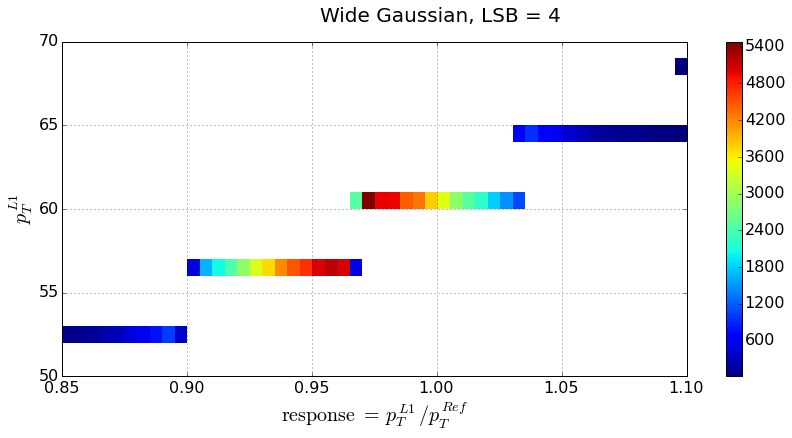

In [176]:
a,b,c,d = plt.hist2d(rsp_wide_out, jets_wide_out.pt, cmin=0.1, bins=[nbins_rsp, 20], range=[range_rsp, [50, 70]])
plt.ylabel(ptL1_str)
plt.xlabel(rsp_str)
plt.colorbar()
plt.suptitle('Wide Gaussian, LSB = 4', fontsize=20)
plt.grid(which='both')

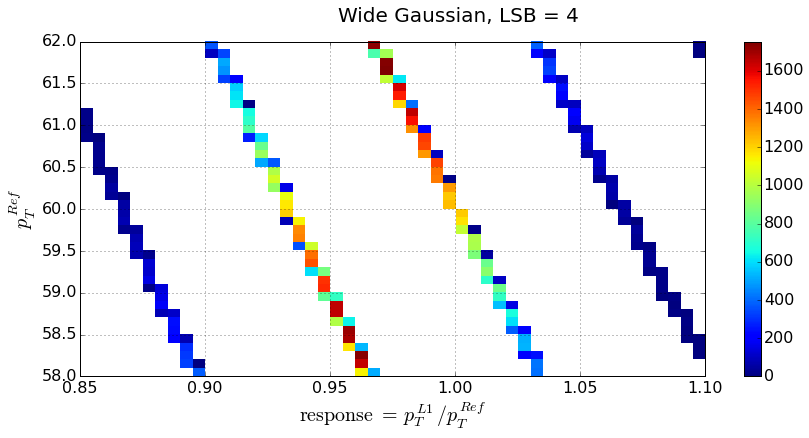

In [177]:
a,b,c,d = plt.hist2d(rsp_wide_out, jets_wide_out.ptRef, cmin=0.1, bins=[nbins_rsp, 40], range=[range_rsp, [58, 62]])
plt.xlabel(rsp_str)
plt.ylabel(ptRef_str)
# plt.axvline(16./18.)
# plt.axvline(20./22.)
# plt.axvline(16./22.)
# plt.axvline(12./18.)
plt.legend(loc=0)
plt.colorbar()
plt.suptitle("Wide Gaussian, LSB = 4", fontsize=20)
plt.grid(which='both')

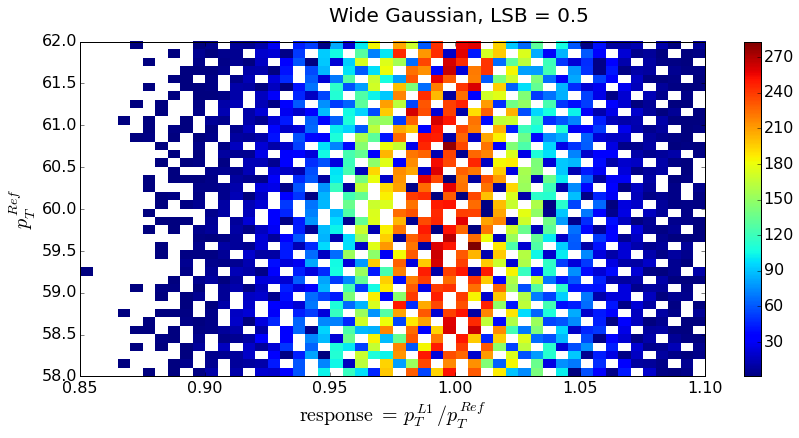

In [178]:
a,b,c,d = plt.hist2d(rsp_wide_intern, jets_wide_out.ptRef, cmin=0.1, bins=[nbins_rsp, 40], range=[range_rsp, [58, 62]])
plt.xlabel(rsp_str)
plt.ylabel(ptRef_str)
plt.legend(loc=0)
plt.colorbar()
plt.suptitle("Wide Gaussian, LSB = 0.5", fontsize=20)

## When does this occur?

Now we try and answer the question: **at what pT scale does the LSB stop drastically affecting the response distribution?**

Let us consider a bin of $p_{T}^{Ref} \in [g_0, g_1]$, for various values of $p_T^{L1}$ with a LSB. Then we require that the largest response values from one bin of $p_T^{L1}$ overlaps with the lowest response values of the next largest $p_T^{L1}$ bin:

\begin{equation}
\frac{p_T^{L1}}{g_0} \gt \frac{p_T^{L1} + LSB}{g_1}
\end{equation}

To simplify things, we rearrange slightly:

\begin{equation}
p_T^{L1} \gt LSB \times \frac{g_0}{g_1 - g_0}
\end{equation}

Since our standard binning has $g_1 - g_0 = 4$, we can simplify further:

\begin{equation}
p_T^{L1} \gt LSB \times \frac{g_0}{4}
\end{equation}

And thus in the scenario where LSB = 4 (as usual), we end up with the condition

\begin{equation}
p_T^{L1} \gt g_0 \ \ (LSB = 4)
\end{equation}

in order to avoid the dips. Note that this still does not promise a completely smooth distribution, nor does it necessarily avoid the smaller peaks.

We can compare with the scenario where LSB = 0.5:

\begin{equation}
p_T^{L1} \gt \frac{g_0}{8} \ \ (LSB = 0.5)
\end{equation}


For LSB = 0.5, unless we are considering jets with response $ \lesssim \frac{1}{8}$, we should not enounter any issues.

For LSB = 4, any jets with response $\lesssim 1$ will give rise to troughs/peaks. This will obivously cause issues, since we expect about half our jets should have response < 1!

A more realistic condition is that the gap is small enough to be avoided by choice binning of the response histogram. Let $\delta$ denote the maximum size of any 'gap' that can be avoided through smart binning. Then we have:

$$
\begin{equation}
\frac{p_T^{L1} + LSB}{g_1} - \frac{p_T^{L1}}{g_0} \lt \delta
\\
p_T^{L1} \left(\frac{g_0 - g_1}{g_0g_1}\right) + \frac{LSB}{g_1} \lt \delta
\end{equation}
$$

Now substitue LSB = 4, and $g_1 - g_0 = 4$:

$$
\begin{equation}
p_T^{L1} \left(\frac{-4}{g_0g_1}\right) + \frac{4}{g_1} \lt \delta
\\
\frac{4}{g_0g_1} \left( g_0 - p_T^{L1}\right) \lt \delta
\end{equation}
$$

(Note that the case $\delta = 0$ is the first condition we derived above, and we recover the condition $p_T^{L1} > g_0$)